In [ ]:
!pip install -U SoMaJo

In [ ]:
!pip install -U seaborn

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
df = pd.read_csv('../dataset/cefr_leveled_texts.csv', encoding='utf-8')

In [5]:
# remove the Unicode BOM Character (\ufeff) manually
df['text'] = df['text'].str.replace('\ufeff', '')

In [6]:
# remove the advertisement, business card, dictionary entry and menus from A1 level, which can't be correctly tokenized
df = df.drop(index=[1041, 1064, 1068, 1113, 1117, 1223]).reset_index(drop=True)

In [7]:
df.head()

,text,label
0,Hi!\nI've been meaning to write for ages and f...,B2
1,It was not so much how hard people found the c...,B2
2,Keith recently came back from a trip to Chicag...,B2
3,"The Griffith Observatory is a planetarium, and...",B2
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2


In [16]:
df["label"].value_counts()

label
A1    288
B2    286
A2    272
C1    241
B1    205
C2    202
Name: count, dtype: int64

## Standardize the text
The following program parts are generated by AI.

It aims to replace non ASCII characters with ASCII equivalents so that the quality of tagging can be guaranteed.

In [8]:
def flag_and_summarize_non_ascii(df):
    """
    Detects non-ASCII characters, flags them per column, and returns a set of all unique non-ASCII chars.

    Args:
        df (pd.DataFrame): Input DataFrame

    Returns:
        set of unique non-ASCII characters
    """
    df = df.copy()
    non_ascii_chars = set()

    for col in df.select_dtypes(include=['object']).columns:
        # New column name for detected non-ASCII characters
        new_col = f"{col}_non_ascii_chars"

        # Extract non-ASCII characters (if any)
        df[new_col] = df[col].apply(
            lambda x: ''.join([c for c in str(x) if ord(c) > 127])
            if pd.notna(x) else None
        )

        # Update the global set of non-ASCII characters
        unique_chars_in_col = set(''.join(df[new_col].dropna().astype(str)))
        non_ascii_chars.update(unique_chars_in_col)

        # Print column-specific issues
        non_ascii_rows = df[df[new_col].str.len() > 0]
        if not non_ascii_rows.empty:
            print(f"⚠️ Column '{col}' has {len(non_ascii_rows)} rows with non-ASCII characters.")

    # Print global summary
    if non_ascii_chars:
        print("\n=== Unique non-ASCII characters found ===")
        for char in sorted(non_ascii_chars, key=ord):
            print(f"Character: '{char}' | Unicode: U+{ord(char):04X}")
    else:
        print("✅ No non-ASCII characters found.")

    return non_ascii_chars

In [9]:
STANDARDIZATION_MAP = {
    # Whitespace and invisible characters
    '\u00A0': ' ',   # Non-breaking space → regular space

    # Punctuation and symbols
    '¡': '!',        # Inverted exclamation → regular !
    '¢': 'c',        # Cent → 'c'
    '£': 'GBP',      # Pound → 'GBP'
    '§': 'sect',     # Section symbol → 'sect'
    '©': '(copyright)',
    '°': 'deg',      # Degree → 'deg'
    '×': '*',        # Multiplication → '*'
    '•': '-',        # Bullet → hyphen
    '…': '...',      # Ellipsis → '...'

    # Diacritics (normalize to ASCII closest equivalents)
    'Á': 'A', 'Â': 'A', 'Ã': 'A', 'É': 'E', 'Ó': 'O', 'Ú': 'U',
    'á': 'a', 'â': 'a', 'ã': 'a', 'ä': 'a', 'æ': 'ae', 'ç': 'c',
    'è': 'e', 'é': 'e', 'ê': 'e', 'ë': 'e', 'í': 'i', 'î': 'i',
    'ï': 'i', 'ñ': 'n', 'ó': 'o', 'ô': 'o', 'ö': 'o', 'ø': 'o',
    'ú': 'u', 'ü': 'u', 'ā': 'a', 'ć': 'c', 'č': 'c', 'ł': 'l',
    'ū': 'u',

    # Scientific/math symbols (replace with descriptive tokens)
    'µ': 'micro',    # Micro → 'micro'
    '¼': '1/4',      # Fractions → decimals
    '½': '1/2',
    '−': '-',        # Minus → hyphen
    '∼': '~',        # Tilde → ASCII ~
    '⊙': '(circle)', # Math operators → descriptions
    'ℝ': '(real numbers)',

    # Quotes and dashes
    '‘': "'", '’': "'", '“': '"', '”': '"',
    '–': '-', '—': '--',  # En/em dashes → hyphens

    # Currency symbols
    '€': 'EUR', '₦': 'NGN', '₵': 'GHS',

    # Ligatures (expand)
    'ﬁ': 'fi', 'ﬂ': 'fl',
}

In [10]:
def standardize_text(text, standardization_map=STANDARDIZATION_MAP):
    if not isinstance(text, str):
        return text
    # Replace each non-ASCII char using the map
    standardized = []
    for char in text:
        if char in standardization_map:
            standardized.append(standardization_map[char])
        elif ord(char) > 127:  # Fallback for unmapped Unicode
            standardized.append(f'(U+{ord(char):04X})')
        else:
            standardized.append(char)
    return ''.join(standardized)

# Apply to all string columns in a DataFrame
def standardize_dataframe(df, standardization_map=STANDARDIZATION_MAP):
    df_std = df.copy()
    for col in df.select_dtypes(include=['object']).columns:
        df_std[col] = df[col].apply(lambda x: standardize_text(x, standardization_map))
    return df_std

In [11]:
df = standardize_dataframe(df)

In [12]:
non_ascii_chars = flag_and_summarize_non_ascii(df)

✅ No non-ASCII characters found.


In [13]:
from pathlib import Path  # Better path handling

def save_groups_to_parallel_dir(df, group_column, output_dir_name):
    """
    Groups DataFrame and saves each group to CSV in a parallel directory.

    Args:
        df: pandas DataFrame
        group_column: Column name to group by
        parallel_dir_name: Name of the parallel directory to create
    """
    # Get the current script's directory
    script_dir = Path().parent.resolve()

    # Get the parent directory (one level up)
    parent_dir = script_dir.parent

    # Create path to parallel directory
    output_dir = parent_dir / output_dir_name

    # Create directory if it doesn't exist
    output_dir.mkdir(exist_ok=True)

    # Group and save files
    groups = df.groupby(group_column)
    for name, group in groups:
        # Create safe filename
        # safe_name = str(name).translate(str.maketrans('/\\|?*:', '_______'))
        safe_name = str(name)
        filepath = output_dir / f"{safe_name}.csv"
        # Save to CSV
        group.to_csv(filepath, index=False)

    print(f"Saved {len(groups)} groups to {output_dir}")
    return list(groups.groups.keys())

In [14]:
save_groups_to_parallel_dir(df, group_column="label", output_dir_name="dataset")

Saved 6 groups to /home/cometbridge/Documents/SUDcom/dataset


['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

In [16]:
for level in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']:
    globals()[level] = pd.read_csv(f'../dataset/{level}.csv', encoding='utf-8')

## A primitive analysis of the dataset

In [18]:
from somajo import SoMaJo

tokenizer = SoMaJo("en_PTB", split_camel_case=True)

In [19]:
def somajo_tokenize(paragraphs):
    # paragraphs must be an iterable object
    sentences = tokenizer.tokenize_text(paragraphs)

    sentence_count = 0
    token_each_sentence = []

    for sentence in sentences:
        sentence_count += 1

        token_count = sum(1 for _ in sentence)
        token_each_sentence.append(token_count)

    token_count = sum(token_each_sentence)
    avg_length_each_sentence = sum(token_each_sentence) / len(token_each_sentence)

    return sentence_count, token_count, avg_length_each_sentence

In [20]:
### Tokenizing all texts may take up to 1 min

df["stat"] = df["text"].apply(lambda x: somajo_tokenize([x]))
df["sentence_count"] = df["stat"].apply(lambda x: x[0])
df["token_count"] = df["stat"].apply(lambda x: x[1])
df["avg_len_each_sent"] = df["stat"].apply(lambda x: x[2]).round(2)
df = df.drop('stat', axis=1)
df.head()

,text,label,sentence_count,token_count,avg_len_each_sent
0,Hi!\nI've been meaning to write for ages and f...,B2,26,529,20.35
1,It was not so much how hard people found the c...,B2,34,761,22.38
2,Keith recently came back from a trip to Chicag...,B2,14,266,19.00
3,"The Griffith Observatory is a planetarium, and...",B2,16,343,21.44
4,-LRB- The Hollywood Reporter -RRB- It's offici...,B2,18,413,22.94


In [21]:
## include the emails
to_check = df[ (df["label"]=="A1") & (df["avg_len_each_sent"] > 12) ]
for index, value in to_check['text'].items():
    print("=" * 60)
    print(f"Row {index}")
    print(value)

Row 1079
From: Arina Marat, HR Assistant
To: Jane Claret
Subject: Your appointment on 14 March
Dear Ms Claret,
Thank you for your email.
I am writing to confirm your appointment with our HR manager, Mrs Sofia Aronov.
Your appointment will take place at 3 p.m. on Thursday 14 March at our Astana offices in Emerald Towers. 
When you arrive, please go to the reception on the 26th floor and ask for me. I will take you to Mrs Aronov's office. 
We look forward to meeting you soon.
Best regards,
Arina Marat
HR Assistant
Row 1158
o: info@ascot-hotel.co.uk
From: David Mathews
Subject: Booking 2 nights next week
Dear Ascot Hotel,
I would like to reserve an accessible single room for two nights with breakfast on the 22 and 23 of April. Could I have a quiet room with a view if possible, please?
I will arrive at about 10 p.m. and I have an early meeting the next morning, so please could you leave an iron and ironing board in the room?
I have a promotional code (MH2219). Please can you confirm that i

In [22]:
sentence_count = df.groupby('label')['sentence_count'].agg(['mean', 'std']).reset_index().round(2)
sentence_count.attrs['title'] = "Average number of sentences each text"
sentence_count

,label,mean,std
0,A1,15.95,4.17
1,A2,21.90,7.73
2,B1,26.10,17.84
3,B2,26.72,13.91
4,C1,31.34,13.86
5,C2,26.85,11.77


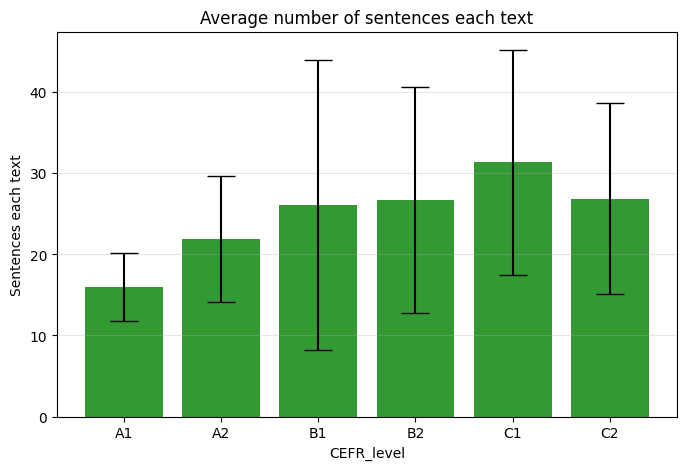

In [23]:
plt.figure(figsize=(8, 5))
plt.bar(sentence_count['label'], sentence_count['mean'], yerr=sentence_count['std'],
        capsize=10, alpha=0.8, color='green')
plt.xlabel('CEFR_level')
plt.ylabel('Sentences each text')
plt.title('Average number of sentences each text')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [24]:
token_count = df.groupby('label')['token_count'].agg(['mean', 'std']).reset_index().round(2)
token_count.attrs['title'] = "Average number of tokens each text"
token_count

,label,mean,std
0,A1,119.79,39.71
1,A2,270.51,138.49
2,B1,472.52,338.21
3,B2,574.20,331.59
4,C1,785.90,347.59
5,C2,804.46,349.16


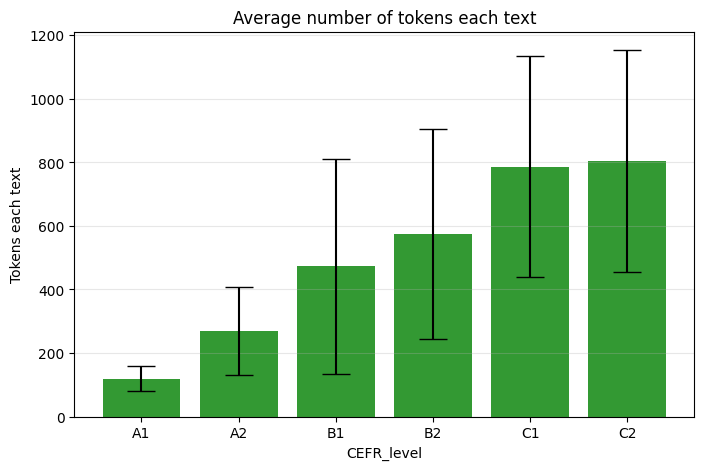

In [25]:
plt.figure(figsize=(8, 5))
plt.bar(token_count['label'], token_count['mean'], yerr=token_count['std'],
        capsize=10, alpha=0.8, color='green')
plt.xlabel('CEFR_level')
plt.ylabel('Tokens each text')
plt.title('Average number of tokens each text')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [26]:
avg_len_each_sent = df.groupby('label')['avg_len_each_sent'].agg(['mean', 'std']).reset_index().round(2)
avg_len_each_sent.attrs['title'] = "Average number of tokens each sentence"
avg_len_each_sent

,label,mean,std
0,A1,7.51,1.83
1,A2,12.05,3.81
2,B1,18.24,4.17
3,B2,21.30,3.99
4,C1,25.32,4.19
5,C2,30.68,6.03


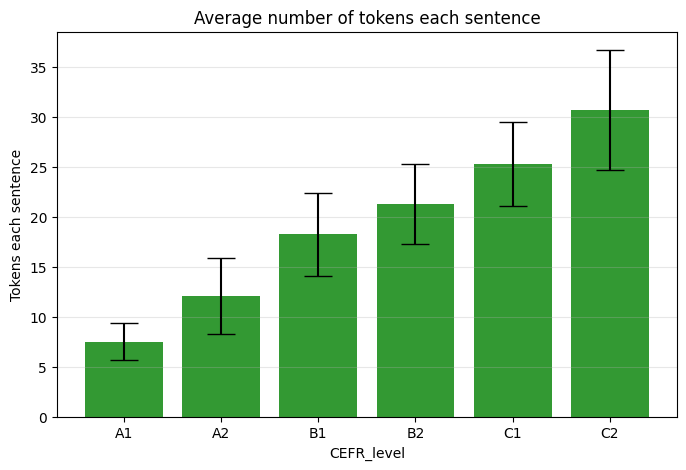

In [27]:
plt.figure(figsize=(8, 5))
plt.bar(avg_len_each_sent['label'], avg_len_each_sent['mean'], yerr=avg_len_each_sent['std'],
        capsize=10, alpha=0.8, color='green')
plt.xlabel('CEFR_level')
plt.ylabel('Tokens each sentence')
plt.title('Average number of tokens each sentence')
plt.grid(axis='y', alpha=0.3)
plt.show()